<br>Model from:
https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb

-----------------------------------------
# Data visualization

In [40]:
%matplotlib inline
%load_ext autoreload
%autoreload

import numpy as np 
import pandas as pd 
from glob import glob 
from skimage.io import imread 
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
# from keras.applications.nasnet import NASNetMobile
# from keras.applications import NASNetMobile
# from keras.applications.xception import Xception
from keras.utils.vis_utils import plot_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average
from keras.layers import Input, Concatenate, GlobalMaxPooling2D, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, Activation
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam
from keras.models import load_model
from keras import utils as np_utils
# from livelossplot import PlotLossesKeras

import cv2

from src.dataGenerator import *

# import src.constants

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11151711022383013487
]


In [42]:
# Output files
OUTPUT_DIR = "output_model2_2/"
# MODEL_SUMMARY_FILE = OUTPUT_DIR + "model_summary.txt"
MODEL_PLOT_FILE = OUTPUT_DIR + "model_plot.png"

TRAINING_LOGS_FILE_1 = OUTPUT_DIR + "training_logs_no_aug.csv"
MODEL_FILE_1 = OUTPUT_DIR + "model_no_aug.h5"
TRAINING_PLOT_FILE_1 = OUTPUT_DIR + "training_no_aug.png"
VALIDATION_PLOT_FILE_1 = OUTPUT_DIR + "validation_no_aug.png"
ROC_PLOT_FILE_1 = OUTPUT_DIR + "roc_no_aug.png"

TRAINING_LOGS_FILE_2 = OUTPUT_DIR + "training_logs_aug.csv"
MODEL_FILE_2 = OUTPUT_DIR + "model_aug.h5"
TRAINING_PLOT_FILE_2 = OUTPUT_DIR + "training_aug.png"
VALIDATION_PLOT_FILE_2 = OUTPUT_DIR + "validation_aug.png"
ROC_PLOT_FILE_2 = OUTPUT_DIR + "roc_aug.png"

KAGGLE_SUBMISSION_FILE_1 = OUTPUT_DIR + "kaggle_submission_no_aug.csv"
KAGGLE_SUBMISSION_FILE_2 = OUTPUT_DIR + "kaggle_submission_aug.csv"

# Hyperparams
SAMPLE_COUNT = 85000 #??? why only 85000
TRAINING_RATIO = 0.9
IMAGE_SIZE = 96
EPOCHS = 13
BATCH_SIZE = 192
VERBOSITY = 1
TESTING_BATCH_SIZE = 5000

In [43]:
data = pd.read_csv('data/train_labels.csv')
print(data['label'].value_counts())
training_data, validation_data = train_test_split(data, train_size=TRAINING_RATIO, stratify=data['label'])
print(training_data['label'].value_counts())
print(validation_data['label'].value_counts())

0    130908
1     89117
Name: label, dtype: int64
0    117817
1     80205
Name: label, dtype: int64
0    13091
1     8912
Name: label, dtype: int64


/Users/yevhenp/anaconda3/envs/keras-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [44]:
# Parameters
params = {'dim': (IMAGE_SIZE, IMAGE_SIZE),
          'batch_size': BATCH_SIZE,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True,
          'augmentation': True}

training_generator_with_aug = DataGenerator(training_data.id, training_data.label, **params)
validation_generator_with_aug = DataGenerator(validation_data.id, validation_data.label, **params)

Data augmentation enabled
Data augmentation enabled


Original image
Augmented images


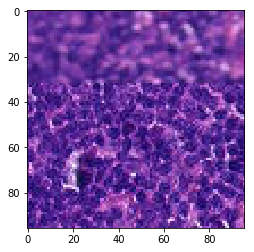

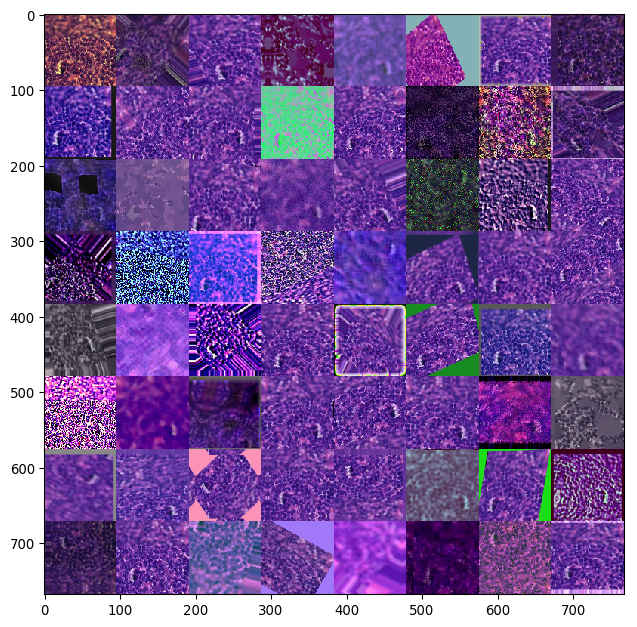

In [45]:
path = "data/train/" + training_data.id[np.random.randint(training_data.shape[0])] + ".tif"
image = readImage(path)
plt.figure()
print("Original image")
plt.imshow(image)
print("Augmented images")
aug_images = training_generator_with_aug.augment([image], show = True)
# seed(training_data.shape[0])
# print(training_data.id[8])
# print(random())

In [46]:
# Model
def create_model(file = ''):
    kernel_size = (3,3)
    pool_size= (2,2)
    first_filters = 32
    second_filters = 64
    third_filters = 128

    dropout_conv = 0.3
    dropout_dense = 0.5

    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                     input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(Conv2D(first_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size)) 
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(second_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(second_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(third_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(third_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    #model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(256, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(2, activation = "sigmoid"))
    
    if (os.path.exists(file) == True):
        model = load_model(file)

    # Compile the model
    model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])
    model.summary()

    plot_model(model,
               to_file=MODEL_PLOT_FILE,
               show_shapes=True,
               show_layer_names=True)
    
    return model

def train(model, training_generator, validation_generator, model_file, logs_file):
    model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=6,
                    epochs=EPOCHS,
                            callbacks=[ModelCheckpoint(model_file,
                                                     monitor='val_acc',
                                                     verbose=VERBOSITY,
                                                     save_best_only=True,
                                                     mode='max'),
                                         CSVLogger(logs_file,
                                                   append=False,
                                                   separator=';')])

In [47]:
model_with_aug = create_model(MODEL_FILE_1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_31 (Batc (None, 92, 92, 32)        128       
_________________________________________________________________
activation_31 (Activation)   (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 44, 44, 64)        18432     
__________

In [38]:
history = train(model = model_with_aug, 
            training_generator = training_generator_with_aug,
            validation_generator = validation_generator_with_aug,
            model_file = MODEL_FILE_2,
            logs_file = TRAINING_LOGS_FILE_2)

Epoch 1/13


Process ForkPoolWorker-35:
Process ForkPoolWorker-33:
Process ForkPoolWorker-31:
Process ForkPoolWorker-30:
Process ForkPoolWorker-34:
Process ForkPoolWorker-32:
Process ForkPoolWorker-29:
Process ForkPoolWorker-27:
Process ForkPoolWorker-36:
Process ForkPoolWorker-28:
Process ForkPoolWorker-26:
Process ForkPoolWorker-25:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/yevhenp/anaconda3/envs/keras-env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/yevhenp/anaconda3/envs/keras-env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/yevhenp/anaconda3/envs/keras-env/lib/python3.6/mult

  File "/Users/yevhenp/anaconda3/envs/keras-env/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/yevhenp/anaconda3/envs/keras-env/lib/python3.6/multiprocessing/queues.py", line 346, in put
    with self._wlock:
  File "/Users/yevhenp/anaconda3/envs/keras-env/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/Users/yevhenp/anaconda3/envs/keras-env/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/Users/yevhenp/anaconda3/envs/keras-env/lib/python3.6/multiprocessing/connection.py", line 398, in _send_bytes
    self._send(buf)
  File "/Users/yevhenp/anaconda3/envs/keras-env/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._h

Epoch 1/13


KeyboardInterrupt: 

In [50]:
def plot_epochs(history, training_plot_file, validation_plot_file):
    # Training plots
    epochs = [i for i in range(1, len(history.history['loss'])+1)]

    plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
    plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
    plt.legend(loc='best')
    plt.title('training')
    plt.xlabel('epoch')
    plt.savefig(training_plot_file, bbox_inches='tight')
    plt.close()

    plt.plot(epochs, history.history['acc'], color='blue', label="training_accuracy")
    plt.plot(epochs, history.history['val_acc'], color='red',label="validation_accuracy")
    plt.legend(loc='best')
    plt.title('validation')
    plt.xlabel('epoch')
    plt.savefig(validation_plot_file, bbox_inches='tight')
    plt.close()

In [51]:
def plot_AUC(model, testing_generator, model_file, plot_file):
    # ROC testing plot
    model.load_weights(model_file)
    predictions = model.predict_generator(testing_generator, steps=len(testing_generator), verbose=VERBOSITY)
    false_positive_rate, true_positive_rate, threshold = roc_curve(testing_generator.classes, predictions)
    area_under_curve = auc(false_positive_rate, true_positive_rate)
    
    print("False positive: ", false_positive_rate)
    print("True positive: ", true_positive_rate)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    plt.savefig(plot_file, bbox_inches='tight')
    plt.close()


In [52]:
def test(model, file):
    testing_files = glob(os.path.join('data/test/','*.tif'))
    submission = pd.DataFrame()
    for index in range(0, len(testing_files), TESTING_BATCH_SIZE):
        data_frame = pd.DataFrame({'path': testing_files[index:index+TESTING_BATCH_SIZE]})
        data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[2].split(".")[0])
        data_frame['image'] = data_frame['path'].map(imread)
        images = np.stack(data_frame.image, axis=0)
        predicted_labels = [model.predict(np.expand_dims(image/255.0, axis=0))[0][0] for image in images]
        predictions = np.array(predicted_labels)
        data_frame['label'] = predictions
        submission = pd.concat([submission, data_frame[["id", "label"]]])
    submission.to_csv(file, index=False, header=True)

In [53]:
# Parameters
params = {'dim': (IMAGE_SIZE, IMAGE_SIZE),
          'batch_size': BATCH_SIZE,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': False,
          'augmentation': False}

testing_generator = DataGenerator(validation_data.id, validation_data.label, **params)
# plot_epochs(history, TRAINING_PLOT_FILE_1, VALIDATION_PLOT_FILE_1)
plot_AUC(model_with_aug, testing_generator, MODEL_FILE_2, ROC_PLOT_FILE_2)

OSError: Unable to open file (unable to open file: name = 'output_model2_2/model_aug.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [15]:
test(model = model_with_aug, file = KAGGLE_SUBMISSION_FILE_2)

In [ ]:
print("Run model without augmentation")

In [ ]:
# Parameters
params = {'dim': (IMAGE_SIZE, IMAGE_SIZE),
          'batch_size': BATCH_SIZE,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True,
          'augmentation': False}

training_generator_with_aug = DataGenerator(training_data.id, training_data.label, **params)
validation_generator_with_aug = DataGenerator(validation_data.id, validation_data.label, **params)

In [17]:
model_no_aug = create_model(MODEL_FILE_1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_7 (Batch (None, 92, 92, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 44, 44, 64)        18432     
__________

In [ ]:
history = train(model = model_no_aug, 
                training_generator = training_generator_no_aug,
                validation_generator = validation_generator_no_aug,
                model_file = MODEL_FILE_1,
                logs_file = TRAINING_LOGS_FILE_1)

Epoch 1/13
 114/1019 [==>...........................] - ETA: 9:01 - loss: 0.3598 - acc: 0.8469

170/170 [==============================] - 19s 111ms/step
False positive:  [0.00000000e+00 1.82515057e-04 1.82515057e-04 ... 9.84607897e-01
 9.88136521e-01 1.00000000e+00]
True positive:  [0.         0.02541901 0.0295009  ... 1.         1.         1.        ]


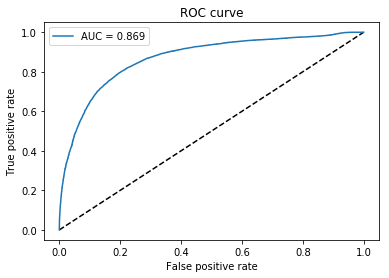

In [18]:
# plot_epochs(history, TRAINING_PLOT_FILE_2, VALIDATION_PLOT_FILE_2)
plot_AUC(model_no_aug, testing_generator, MODEL_FILE_1, ROC_PLOT_FILE_1)

In [19]:
test(model = model_no_aug, file = KAGGLE_SUBMISSION_FILE_1)